In [1]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import gensim
from gensim.test.utils import common_texts

# load config
with open('config.json', 'r') as f:
    config = json.load(f)
cwd = os.getcwd()
os.chdir(config['REPODIR'])
import Utils as U
from Corpus import Corpus
os.chdir(cwd)

from collections import Counter, defaultdict
import itertools

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
import pickle as pkl
from sklearn.decomposition import PCA
import nltk

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# with open("data_vFinal.pkl", "rb") as infile:
        # data = pkl.load(infile)

data = U.load_file('data_vFF.pkl', 'pkl', config['DATADIR'])

# Just table of contents
# data.pop(3064)

In [3]:
data_df = pd.DataFrame(data)
data_df.head()

,author_id,author_name,book_id,gutenbergbookid,title,text,text_lines,authoryearofbirth,authoryearofdeath,downloads,subjects,topic,Sub_A,Sub_B,Sub_C,str_text_lines,passage_key
0,494,"Lincoln, Abraham",PG8,PG8,Abraham Lincoln's Second Inaugural Address,"[to header material., , ***, , Lincoln's Secon...",17,1809.0,1865.0,25.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,17,PG8_17
1,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,"[I have no lawful right to do so, and I have n...",77,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,77,PG9_77
2,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,[for a minority of their own will secede from ...,277,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,277,PG9_277
3,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,"[in both cases, and a few break over in each. ...",327,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,327,PG9_327
4,494,"Lincoln, Abraham",PG9,PG9,Abraham Lincoln's First Inaugural Address,[There is some difference of opinion whether t...,127,1809.0,1865.0,36.0,{'United States -- Politics and government -- ...,United States,1861-1865,Politics and government,Presidents,127,PG9_127


In [70]:
baby_size = int(data_df.author_id.nunique() * .015 // 1)
baby_set = set(data_df.author_id.sample(baby_size))
baby_df = data_df[data_df.author_id.apply(lambda X: X in baby_set)]
baby_df.to_csv('baby_data.csv', index = False)

baby = baby_df.to_dict(orient='records')

In [71]:
len(baby)

9

In [5]:
subsample = data_df.sample(9000, random_state=0)

subject_b = [s for s in subsample['Sub_B']]
other_subject = [s if s != 'Fiction' else subject_b[idx] for idx, s in enumerate(subsample['Sub_A']) ]

subsample['sub'] = other_subject
subsample = subsample[subsample['authoryearofbirth'] > 1750]

<Axes: xlabel='sub'>

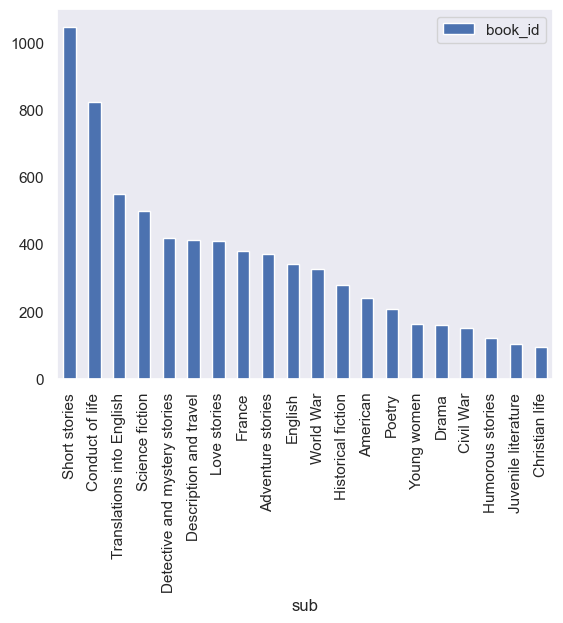

In [6]:
subsample.groupby('sub').agg({'book_id':'count'}).sort_values(by = 'book_id', ascending=False).head(20).plot(kind='bar')

Fetch works for every book

In [7]:
data = subsample.to_dict(orient='records')

In [8]:
def sent_tokenize(text, language="english"):
    """
    Return a sentence-tokenized copy of *text*,
    using NLTK's recommended sentence tokenizer
    (currently :class:`.PunktSentenceTokenizer`
    for the specified language).

    :param text: text to split into sentences
    :param language: the model name in the Punkt corpus
    """
    tokenizer = pkl.load(f"tokenizers/punkt/{language}.pickle")
    return tokenizer.tokenize(text)

In [ ]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

#Our sentences we like to encode
sentences = ['This framework generates embeddings for each input sentence',
    'Sentences are passed as a list of string.', 
    'The quick brown fox jumps over the lazy dog.']

#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

#Print the embeddings
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding:", embedding)
    print("")

In [69]:
data_text = [dat['text'] for dat in baby]
tokenizer = nltk.RegexpTokenizer(r'\w+')

sentence_embeddings = [model.encode(text) for text in data_text]


KeyboardInterrupt: 

In [46]:
# baby = data[:1000]

In [47]:
for idx, d in enumerate(baby):
    d['mean_vector'] = np.array(sentence_embeddings[idx]).mean(axis = 0)
    if not d['mean_vector'].shape:
        d['mean_vector'] = np.zeros((100,))
    d['key'] = str(d['book_id']) + str(d['text_lines'])
    #  d['subject'] = catalog[catalog['book_id'] == d['book_id']].iloc[0, 9]

In [48]:
# mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape and d['subject'] != 'Other'])
mean_vectors = np.array([d['mean_vector'] for d in baby if d['mean_vector'].shape])

In [49]:
# ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape and d['subject'] != 'Other']
ids = [idx for idx, d in enumerate(baby) if d['mean_vector'].shape]

In [59]:
titles = [baby[idx]['title'] for idx in ids]
subjects = [data[idx]['Sub_A'] for idx in ids]
# decade = [int(data[idx]['decade']) for idx in ids]
yob = [int(baby[idx]['authoryearofbirth']) for idx in ids]
yod = [int(baby[idx]['authoryearofdeath']) for idx in ids]
topics = [baby[idx]['topic'] for idx in ids]
downloads = [int(baby[idx]['downloads']) for idx in ids]
authors = [baby[idx]['author_name'] for idx in ids]
# gender = [1 if data[idx]['gender'] == "F" else 0 for idx in ids]
# penname =[1 if data[idx]['penname'] == "Y" else 0 for idx in ids]
# pn_gend = [str(penname[idx]) + str(gender[idx]) for idx in ids]

In [36]:
data[2]

{'author_id': 8634,
 'author_name': 'Willis, Nathaniel Parker',
 'book_id': 'PG47690',
 'gutenbergbookid': 'PG47690',
 'title': 'Canadian Scenery, Volume 1 (of 2)',
 'text': ['defensive position. The New Englanders made every preparation for an',
  'attack on Montreal by land; but the English forces destined for the',
  'cooperation by the St. Lawrence river were required for Portugal, and',
  'thus the Marquis de Vandreuil had time to make better preparations for',
  'defence. The ensuing year (1709) was spent by the English in reducing',
  'Acadia, now Nova Scotia; and when the combined land and sea expedition',
  'against Canada took place in 1711, it was so ill-managed, and the',
  'British fleet, owing to tempestuous weather and ignorance of the coast,',
  'met with so many disasters,—losing by shipwreck in one day (the 22d of',
  'August) eight transports, 884 officers, soldiers, and seamen—that the',
  'expedition returned to Boston, and the restoration of peace between',
  'Fra

In [51]:
two_dim = mean_vectors



In [39]:
# two_dim = PCA(random_state =0).fit_transform(mean_vectors)[:1000,]
two_dim = PCA(random_state =0).fit_transform(mean_vectors)


In [52]:
xPCA = two_dim[:,0]; yPCA = two_dim[:,1]
xPCA.shape

(1000,)

<Axes: >

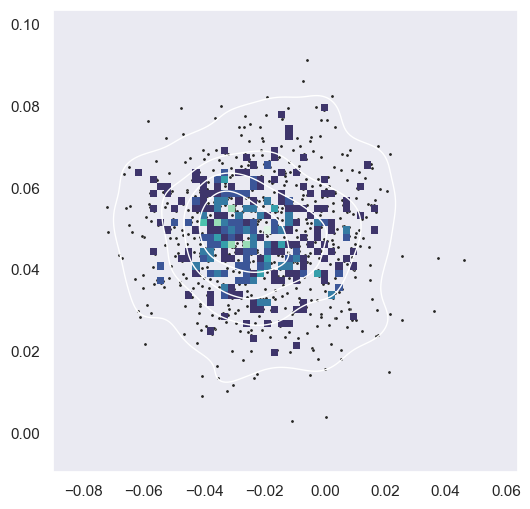

In [53]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=xPCA, y=yPCA, s =5, color=".15")
sns.histplot(x=xPCA, y=yPCA, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=xPCA, y=yPCA, levels=5, color="w", linewidths=1)

In [54]:
import plotly.express as px

def pca_scatterplot_3D(model, user_input=None, color_map=None, sentences = None):

    # three_dim = user_input[:,:3]
    three_dim = PCA(random_state=0).fit_transform(user_input)[:,:3]

    df = pd.DataFrame(three_dim)
    df['Label'] = color_map
    df['sentence'] = sentences

    plot_figure = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'Label', hover_name = 'sentence', size_max = 2)

    plot_figure.show()

In [ ]:

# For use in the famous literature set
# decade_gender = [int(str(decade[idx]) + str(gender[idx])) for idx in ids]

In [55]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(two_dim)
clusters = gmm.predict(mean_vectors)

In [60]:
# pca_scatterplot_3D(data, user_input = two_dim, color_map = [str(c) for c in clusters], sentences = titles)
# pca_scatterplot_3D(data, user_input = two_dim, color_map = yob, sentences = authors)
pca_scatterplot_3D(data, user_input = two_dim, color_map =clusters, sentences = subjects)


In [36]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters = 6).fit(mean_vectors)

cluster_labels = [str(lab) for lab in clustering.labels_]

In [61]:
extract_data = []

for i, idx in enumerate(ids):
    # data[idx]['cluster'] = str(cluster_labels[i])
    baby[idx]['cluster'] = str(clusters[i])
    extract_data.append(baby[idx].copy())



In [66]:
t = pd.DataFrame(extract_data).groupby(by = ['cluster', 'topic']).agg('count')

In [63]:
ed = pd.DataFrame(extract_data)

In [ ]:
ed.columns

Index(['author_id', 'author_name', 'book_id', 'gutenbergbookid', 'title',
       'text', 'text_lines', 'authoryearofbirth', 'authoryearofdeath',
       'downloads', 'subjects', 'topic', 'Sub_A', 'Sub_B', 'Sub_C', 'sub',
       'vectors', 'mean_vector', 'key', 'cluster'],
      dtype='object')

In [64]:
ed[ed['topic']=='Translations into English'].Sub_C.unique()

array([nan, 'graf', 'Paris (France)', '1818-1883', 'French fiction',
       'German fiction', 'Ireland', 'Names', '1860-1904',
       'History and criticism', 'Autobiographical fiction', 'Chouans',
       'German poetry'], dtype=object)

In [67]:
t['key'].unstack(0)

cluster,0,1,2,3,4
topic,,,,,
19th century,22.0,1.0,12.0,4.0,NaN
Adventure stories,NaN,1.0,NaN,5.0,3.0
American,NaN,1.0,NaN,1.0,NaN
Biography,4.0,NaN,1.0,NaN,NaN
Conduct of life,3.0,NaN,1.0,NaN,NaN
Description and travel,19.0,NaN,4.0,NaN,2.0
Detective and mystery stories,NaN,1.0,1.0,9.0,6.0
Drama,2.0,1.0,9.0,2.0,1.0
England,1.0,NaN,2.0,NaN,NaN


In [ ]:
topic_set = ed.topic.unique()
topic_set

array(['Fiction', 'Adventure stories', 'Juvenile literature',
       'Juvenile fiction', 'Translations into English', 'History',
       '19th century', 'Science fiction', 'Great Britain',
       'Short stories', 'Detective and mystery stories',
       'Description and travel', 'American', 'Biography', 'United States',
       'England', 'World War', 'English', 'Poetry', 'Drama',
       'English wit and humor', 'Historical fiction', 'France',
       'Love stories', 'Social life and customs', 'Children',
       'Conduct of life', 'Young women'], dtype=object)